# Stability and Performance of Wind-Aware Path Following Guidance for Small Fixed-Wing Aircraft
Author: Thomas Stastny ([tstastny@ethz.ch](mailto:tstastny@ethz.ch))

This notebook contains scripts useful for the analysis of stability properties for a wind-aware nonlinear differential geometric path following guidance law for small fixed-wing unmanned aircraft.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import optimize
plt.rcParams.update({"text.usetex": True})

In [2]:
# functions
# ---------


# function to evaluate derivative of f w.r.t. path orientation angle lP
def eval_df(l, a):
    # inputs:
    # l         path orientation angle
    # a         wind ratio
    # outputs:
    # df/dl

    sinl = np.sin(l)
    sin2l = sinl*sinl
    cosl = np.cos(l)
    a2 = a*a
    sin4l = sin2l*sin2l
    one_m_a2sin2l = 1 - a2 * sin2l
    one_m_a2sin2l_3_2 = one_m_a2sin2l**(3/2)

    if a == 1:
        return 1 - 2 * sin2l + sin4l
    else:
        return a*(a*(a2 * sin4l - 2 * sin2l + 1) + cosl * one_m_a2sin2l_3_2) / one_m_a2sin2l_3_2


# function to evaluate f
def eval_f(l, a):
    # inputs:
    # l         path orientation angle
    # a         wind ratio
    # outputs:
    # f

    sinl = np.sin(l)
    sin2l = sinl * sinl
    cosl = np.cos(l)
    a2 = a * a
    a2sin2l = a2 * sin2l

    if a2sin2l >= 1.0:
        return 2
    else:
        return a2 * sinl * cosl / np.sqrt(1 - a2sin2l) + a * sinl


# function to evaluate critical f approximation
def eval_f_crit_analytic_approx(a):
    # inputs:
    # a         wind ratio
    # outputs:
    # fcrit

    return 2*(1 - np.sqrt(1 - a))


def eval_sum_sq_f_crit_approx_err(c, x, e):
    res = e + x.transpose().dot(c)
    return res.dot(res)

In [3]:
# allocate arrays
# ---------------

len_data = 501

wrd1 = np.linspace(0, 0.995, len_data - 100)
wrd2 = np.linspace(0.995, 1, 101)
wind_ratio_data = np.concatenate((wrd1[:len_data - 101], wrd2))

path_ori_crit_num_sol = np.zeros(len_data)      # numerical solution of critical path orientation per wind ratio

f_crit_analytic_approx = np.zeros(len_data)     # approximation of critical f value per wind ratio
f_crit_approx2_sol = np.zeros(len_data)         # critical f value per wind ratio
f_crit_num_sol = np.zeros(len_data)             # numerical solution of critical f value per wind ratio

## Solutions and Approximations
### Numerically solve for critical path orientation ${\lambda_P}^\star$
The critical path orientation ${\lambda_P}^\star$ for a given wind ratio $\alpha_W$ maximizes $f_W$. To solve for this relationship we find the roots of $\frac{\partial f_W}{\partial \lambda_P}\left(\lambda_P, \alpha_W\right)=0$.

In [4]:
verbose_sol_output = False  # enable to display each solution status and value

a_solution_failed = False
for i in range(len_data):
    sol = optimize.root(eval_df, np.pi/2*0.99, args=(wind_ratio_data[i],))
    path_ori_crit_num_sol[i] = sol.x
    if verbose_sol_output:
        print(f'{wind_ratio_data[i]:.2f}' + ':' + str(sol.success) + '; sol = ' + str(sol.x))
    if not sol.success:
        a_solution_failed = True

if a_solution_failed:
    print('ERROR: One ore more numerical solutions failed, enable verbose_sol_output and re-run cell.')

# df(a=0) = 0, define a crit orientation at 0 which follows the trend of the other solutions
path_ori_crit_num_sol[0] = np.pi/2

### Numerical Solution ${f_W}^\star$

In [5]:
for i in range(len_data):
    f_crit_num_sol[i] = eval_f(path_ori_crit_num_sol[i], wind_ratio_data[i])

### Approximation 1: Analytic Approx. ${\tilde{f}_W}^\star$ 

In [6]:
for i in range(len_data):
    f_crit_analytic_approx[i] = eval_f_crit_analytic_approx(wind_ratio_data[i])

f_crit_analytic_approx_err = f_crit_analytic_approx - f_crit_num_sol

### Approximation 2: Analytic Approx. + Poly3
Even though the last approximation was already quite good.. we can do slightly better by fitting a 3rd order polynomial $p^{(3)}$ to our analytic approximation error $\tilde{f}_{W,\text{err}}^\star$.

$p^{(3)}\left(\mathbf{c}, \alpha_W\right) = \left({\boldsymbol{\alpha}_W}^{\circ 3}, {\boldsymbol{\alpha}_W}^{\circ 2}, {\boldsymbol{\alpha}_W}^{\circ 1}, {\boldsymbol{\alpha}_W}^{\circ 0}\right) \mathbf{c}$

where $\mathbf{c}=\left(c_3,c_2,c_1,c_0\right)^T$ are the polynomial coefficients (in decreasing order), and ${\boldsymbol{\alpha}_W}^{\circ n}$ is the set of wind ratios taken to power $n$ via Hadamard (element wise) exponential. 

The polynomial is fit using a constrainted optimization of the form

$\begin{equation}
\min_{\mathbf{c}} \left(\tilde{f}^\star_{W,\text{err}} + p^{(3)}\left(\mathbf{c}, \mathbf{\alpha}_W\right)\right)^T \left(\tilde{f}^\star_{W,\text{err}} + p^{(3)}\left(\mathbf{c},\mathbf{\alpha}_W\right)\right)
\end{equation}$

$\begin{align}
&s.t. & p^{(3)}\left(\mathbf{c}, 0\right) &= 0 & (1) \\
& & p^{(3)}\left(\mathbf{c}, 1\right) &= 0 & (2)
\end{align}$

NOTE: (1) implies c0 = 0, therefore c0 and (1) are omitted from the optimization problem.

In [7]:
wr321 = np.array([wind_ratio_data**3, wind_ratio_data**2, wind_ratio_data])
c0 = -np.array([-0.32313744, 0.31651312, 0.00662432])*0.55                          # coefficients initial guess
cons = ({'type': 'eq', 'fun': lambda c, x: x[:, -1].dot(c), 'args': (wr321,)})      # equality constraint (2)

# optimize
c_sol = optimize.minimize(eval_sum_sq_f_crit_approx_err, c0, args=(wr321, f_crit_analytic_approx_err), constraints=cons)
print(c_sol)

# calculate the polynomial result and add it to the analytic approximation
poly_fun = np.poly1d(np.concatenate((c_sol.x, np.array([0]))))
f_crit_analytic_poly_approx = f_crit_analytic_approx + poly_fun(wind_ratio_data)
f_crit_analytic_poly_approx_err = f_crit_analytic_poly_approx - f_crit_num_sol

     fun: 5.622576748976453e-05
     jac: array([0.07341382, 0.07341382, 0.07341382])
 message: 'Optimization terminated successfully'
    nfev: 18
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 0.1705916 , -0.15937888, -0.01121272])


Next we compare the solutions and approximations for the critical path orientation ${\lambda_P}^\star$ and corresponding critical wind factor ${f_W}^\star$

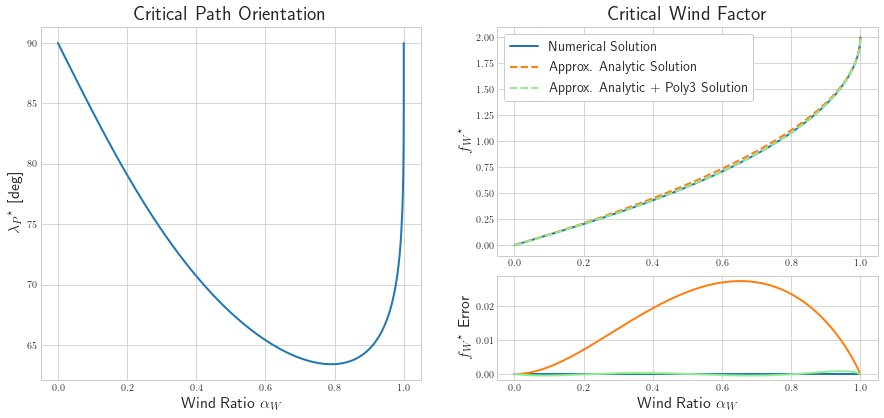

In [29]:
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'legend.frameon': True,
                     'legend.framealpha': 1,
                     'legend.facecolor': 'white',
                     'axes.titlesize': 20,
                     'axes.labelsize': 16,
                     'legend.fontsize': 14})
plot_lw = 2

fig = plt.figure(figsize=(15, 6.5))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

ax1 = fig.add_subplot(spec[:, 0])
ax2 = fig.add_subplot(spec[:2, 1])
ax3 = fig.add_subplot(spec[2, 1])

ax1.plot(wind_ratio_data, np.rad2deg(path_ori_crit_num_sol), linewidth=plot_lw, color='tab:blue')
ax1.set_ylabel(r'${\lambda_P}^\star$ [deg]')
ax1.set_title(r'Critical Path Orientation')
ax1.set_xlabel(r'Wind Ratio $\alpha_W$')

ax2.plot(wind_ratio_data, f_crit_num_sol, linewidth=plot_lw, color='tab:blue', label=r'Numerical Solution')
ax2.plot(wind_ratio_data, f_crit_analytic_approx, '--', linewidth=plot_lw, color='tab:orange', label=r'Approx. Analytic Solution')
ax2.plot(wind_ratio_data, f_crit_analytic_poly_approx, '--', linewidth=plot_lw, color='lightgreen', label=r'Approx. Analytic + Poly3 Solution')
ax2.set_ylabel(r'${f_W}^\star$')
ax2.set_title(r'Critical Wind Factor')
leg2 = ax2.legend(loc="upper left")

ax3.plot([wind_ratio_data[i] for i in [0, -1]], [0, 0], linewidth=plot_lw, color='tab:blue')
ax3.plot(wind_ratio_data, f_crit_analytic_approx_err, linewidth=plot_lw, color='tab:orange')
ax3.plot(wind_ratio_data, f_crit_analytic_poly_approx_err, linewidth=plot_lw, color='lightgreen')
ax3.set_ylabel(r'${f_W}^\star$ Error')
ax3.set_xlabel(r'Wind Ratio $\alpha_W$')

plt.show()
